In [1]:
import os
os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'

import xarray as xr
import numpy as np
import gcsfs
import zarr
import xrft
from pyresample import image, geometry
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
gcs = gcsfs.GCSFileSystem(token='anon')
ds_grid = xr.open_zarr(gcs.get_mapper('pangeo-data/llc4320_surface/grid'),
                           consolidated=True)
ds_grid

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k_p1: 2, time: 9030)
Coordinates:
    CS       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    Depth    (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    PHrefC   float32 ...
    PHrefF   (k_p1) float32 dask.array<shape=(2,), chunksize=(2,)>
    SN       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    XC       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    XG       (face, j_g, i_g) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YC       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YG       (face, j_g, i_g) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    Z        float32 ...
    Zl       float32 ...
    Zp1      (k_p1) float32 dask.array<shape=(2,), chunksize=(2

In [3]:
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
ds_grid_ll = faces_dataset_to_latlon(ds_grid)
ds_grid_ll

<xarray.Dataset>
Dimensions:  (face: 13, i: 17280, i_g: 17280, j: 12960, j_g: 12960, k_p1: 2, time: 9030)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * k_p1     (k_p1) int64 0 1
    CS       (j, i) float32 dask.array<shape=(12960, 17280), chunksize=(4320, 4320)>
    Depth    (j, i) float32 dask.array<shape=(12960, 17280), chunksize=(4320, 4320)>
    PHrefC   float32 15.4017
    PHrefF   (k_p1) float32 dask.array<shape=(2,), chunksize=(2,)>
    SN       (j, i) float32 dask.array<shape=(12960, 17280), chunksize=(4320, 4320)>
    XC       (j, i) float32 dask.array<shape=(12960, 17280), ch

In [4]:
mask = ds_grid_ll.hFacC > 0
keep_coords = ['XC', 'YC']
drop_coords = set(mask.coords) - set(keep_coords) - set(mask.dims)
mask = mask.reset_coords(drop_coords, drop=True)
mask = mask.rename({'XC': 'lon', 'YC': 'lat'})
mask

<xarray.DataArray 'hFacC' (j: 12960, i: 17280)>
dask.array<shape=(12960, 17280), dtype=bool, chunksize=(4320, 4320)>
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
    lon      (j, i) float32 dask.array<shape=(12960, 17280), chunksize=(4320, 4320)>
    lat      (j, i) float32 dask.array<shape=(12960, 17280), chunksize=(4320, 4320)>

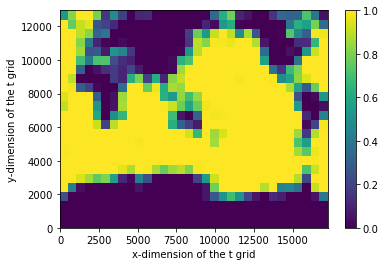

In [5]:
region_size = 540
mask_regions = mask.coarsen(i=region_size, j=region_size).mean().load()
mask_regions.plot()

In [11]:
mask_regions.i.min(), mask_regions.j.min()

(<xarray.DataArray 'i' ()>
 array(269.5), <xarray.DataArray 'j' ()>
 array(269.5))

In [8]:
540/2

270.0

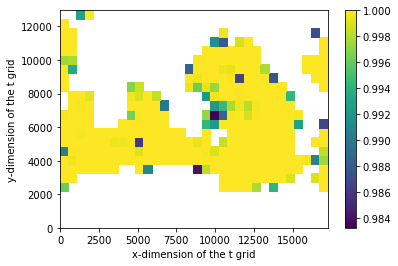

In [12]:
threshold = 0.98
mask_regions.where(mask_regions >= threshold).plot()

In [13]:
mask = mask_regions >= threshold
mask.sum()

<xarray.DataArray ()>
array(321)

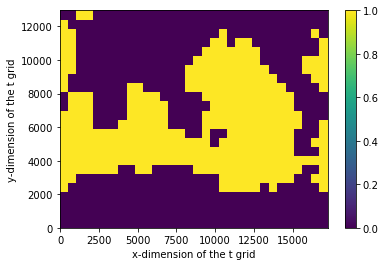

In [14]:
mask.plot()

In [15]:
flat = mask.stack(point=['j', 'i']).reset_index('point')
wet_cells = flat.where(flat).dropna('point').rename('cell_coverage')
# fix offset from coarsen's coords
wet_cells['i'] -= 269.5
wet_cells['j'] -= 269.5
regions = wet_cells.reset_coords().drop('cell_coverage')
regions['i'] = regions.i.astype('i')
regions['j'] = regions.j.astype('i')
regions.attrs['region_size'] = region_size
regions

<xarray.Dataset>
Dimensions:  (point: 321)
Dimensions without coordinates: point
Data variables:
    lon      (point) float32 -32.518307 -55.756996 ... -12.24095 0.4758724
    lat      (point) float32 -74.01137 -73.7896 ... 68.878395 69.47171
    j        (point) int32 2160 2160 2160 2160 2160 ... 11340 11880 12420 12420
    i        (point) int32 0 10260 10800 11340 11880 ... 10260 16200 0 1080 1620
Attributes:
    region_size:  540

In [16]:
# verify we got whole numbers
((regions[['i', 'j']] % 1) > 0 ).sum()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    i        int64 0
    j        int64 0

In [17]:
import json

with open('land_free_regions_llc4320.json', 'w') as f:
    json.dump(regions.to_dict(), f)

In [36]:
17280 / 540

32.0

In [37]:
12960 / 540

24.0